In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import tensorflow as tf
from aml_dl.mdn.model import tf_pushing_model

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [5]:
KMIX = 2

In [6]:
net = tf_pushing_model(dim_input = 4, n_hidden = 1, n_kernels = KMIX)


In [7]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

## Load data

In [8]:
from aml_robot.box2d.data_manager import DataManager

In [9]:
data_manager = DataManager.from_file('data_test.pkl')

In [10]:
print data_manager.get_sample(0,'push_action')

[[ 0.          0.         -0.93809723  0.34637204  2.78789168]]


In [11]:
data_x = data_manager.pack_data_x(['state_start','state_end'])

In [12]:
data_y = data_manager.pack_data_y()

In [13]:
print data_y

[[2.7878916847881401], [3.4576186235141271], [0.17273928666575863], [0.75176172504468186], [6.1231861400927183], [1.7537467231729578], [0.30514956372042612], [4.5440562147213148], [3.9804844517037195], [3.2010545671474193], [0.34986422232216441], [3.6673537530440878], [1.8482862573701027], [6.1686556263463705], [2.4938029649747904], [2.3999914650808183], [1.9661474474230822], [4.9283654218260295], [2.4026829181621752], [4.6399232356168261], [3.6202584650862231], [4.3751519542790556], [2.3318719413533899], [3.6303423117761531], [2.8148967559911249], [4.3129633379920058], [3.4620265986517356], [4.1860511137561423], [1.5684053892704386], [4.6444187882982062], [4.8885899071551533], [4.5070980656719133], [0.020684804063376416], [4.3948196260879788], [2.381840229066964], [5.0292226978235108], [3.5959306701395568], [3.3973721453729104], [0.65835996705823552], [5.7425927192742758], [4.9245961186400953], [3.5662178263211812], [1.3940686275028629], [4.843030779405443], [5.8051331918660347], [5.6

In [24]:
h = sess.run(net['z_hidden'],feed_dict={net['x']: data_x})

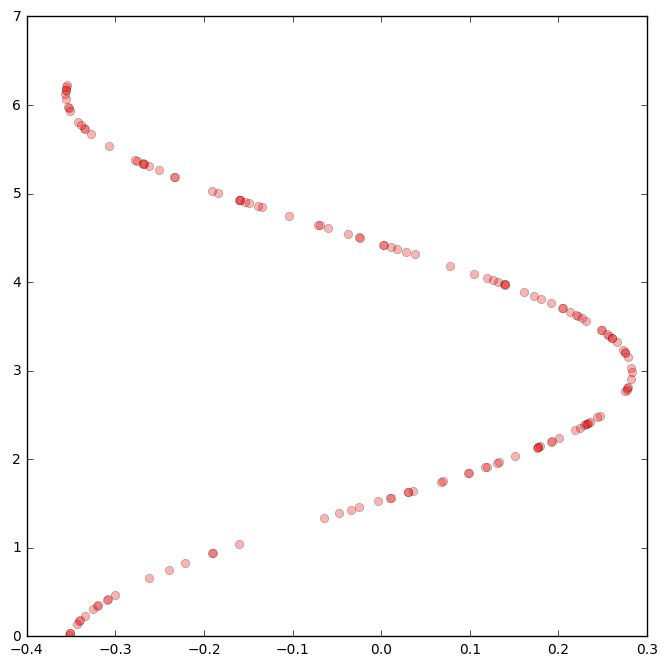

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(h, data_y,'ro', alpha=0.3)
plt.show()

In [16]:
N_EPOCHS = 10000#10000
loss = np.zeros(N_EPOCHS) # store the training progress here.
for i in range(N_EPOCHS):
  sess.run(net['train'],feed_dict={net['x']: data_x, net['y']: data_y})
  loss[i] = sess.run(net['loss'], feed_dict={net['x']: data_x, net['y']: data_y})

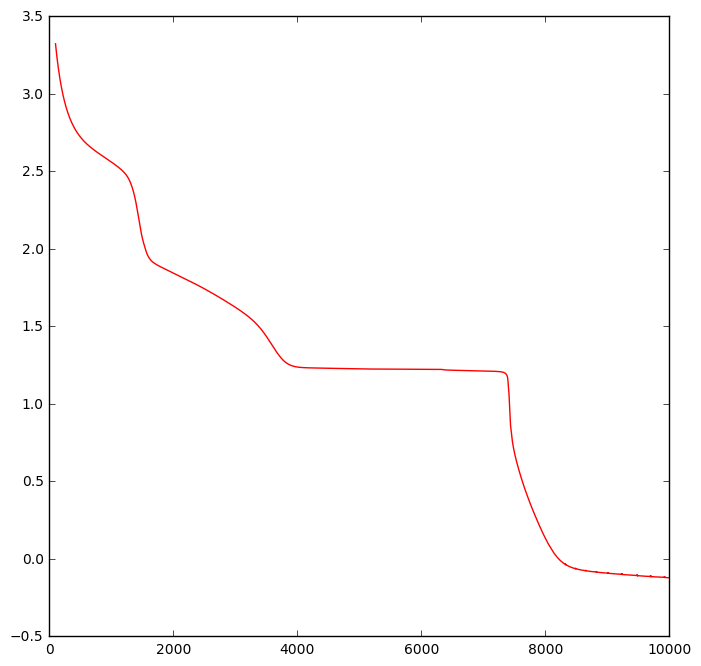

In [17]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(100, N_EPOCHS,1), loss[100:], 'r-')
plt.show()

In [ ]:
h = sess.run(net['z_hidden'],feed_dict={net['x']: data_x})

In [26]:
N_SAMPLES = 100
print N_SAMPLES
x_test = np.float32(np.random.uniform(-5.5, 5.5, (4, N_SAMPLES))).T
len(x_test)

100


100

In [27]:
h_test = sess.run(net['z_hidden'],feed_dict={net['x']: x_test})
NTEST = h_test.size
print NTEST
# x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

def get_pi_idx(x, pdf):
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  print 'error with sampling ensemble'
  return -1

def generate_ensemble(out_pi, out_mu, out_sigma, M = 10):
  NTEST = h_test.size
  result = np.random.rand(NTEST, M) # initially random [0, 1]
  rn = np.random.randn(NTEST, M) # normal random matrix (0.0, 1.0)
  mu = 0
  std = 0
  idx = 0

  # transforms result into random ensembles
  for j in range(0, M):
    for i in range(0, NTEST):
      idx = get_pi_idx(result[i, j], out_pi[i])
      mu = out_mu[i, idx]
      std = out_sigma[i, idx]
      result[i, j] = mu + rn[i, j]*std
  return result

100


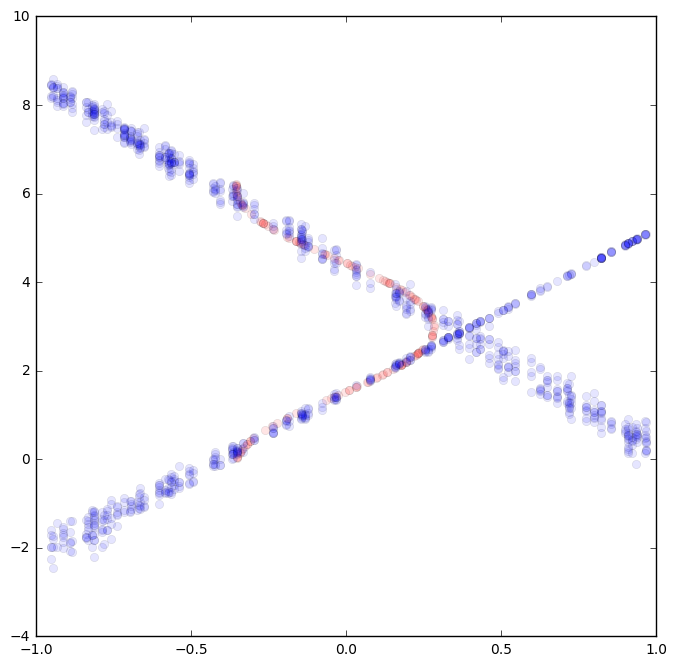

In [28]:
out_pi_test, out_sigma_test, out_mu_test = sess.run([net['pi'], net['sigma'], net['mu']], feed_dict={net['x']: x_test})

y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

plt.figure(figsize=(8, 8))
plt.plot(h,data_y,'ro', h_test,y_test,'bo',alpha=0.1)
plt.show()

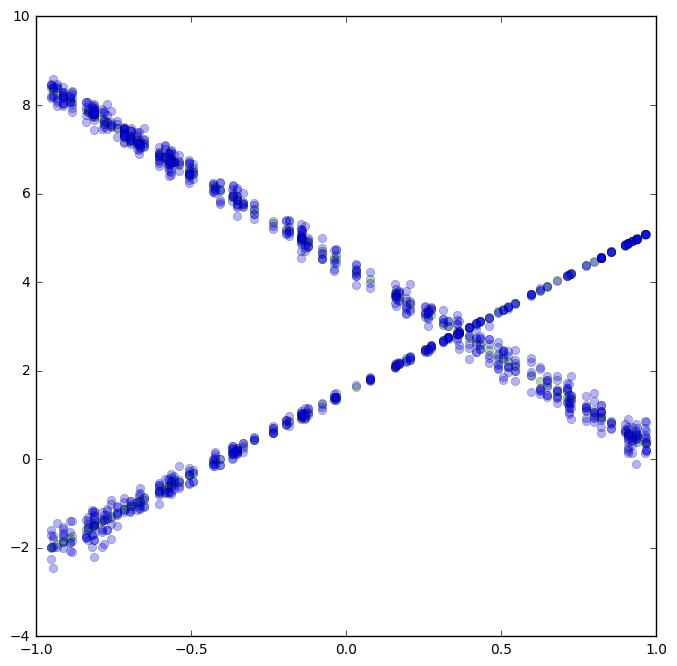

In [29]:
plt.figure(figsize=(8, 8))
plt.plot(h_test,out_mu_test,'go', h_test,y_test,'bo',alpha=0.3)
plt.show()

In [30]:
len(out_pi_test)
x_heatmap_label = np.float32(np.arange(-5,5,0.1))
y_heatmap_label = np.float32(np.arange(-5,5,0.1))

len(x_heatmap_label)

100

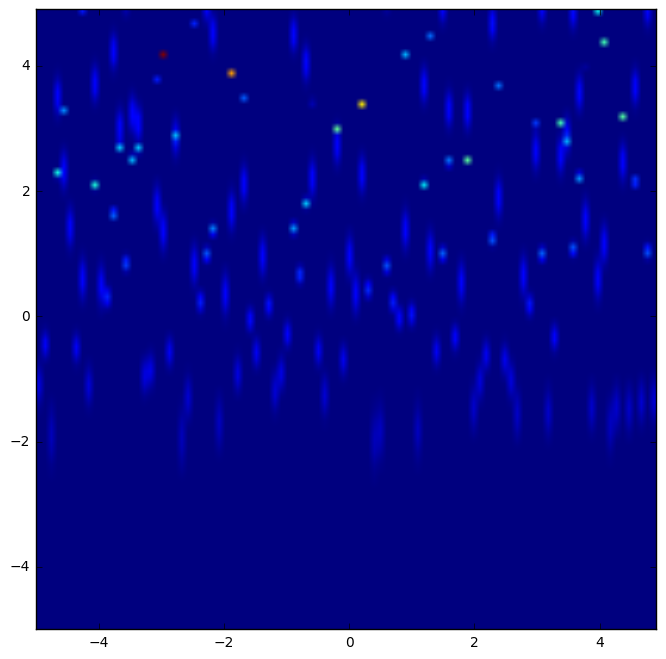

In [31]:


def custom_gaussian(x, mu, std):
  oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi)
  x_norm = (x-mu)/std
  result = oneDivSqrtTwoPI*math.exp(-x_norm*x_norm/2)/std
  return result

def generate_heatmap(out_pi, out_mu, out_sigma, x_heatmap_label, y_heatmap_label):
  N = x_heatmap_label.size
  M = y_heatmap_label.size
  K = KMIX

  z = np.zeros((N, M)) # initially random [0, 1]

  mu = 0
  std = 0
  pi = 0

  # transforms result into random ensembles
  for k in range(0, K):
    for i in range(0, M):
      pi = out_pi[i, k]
      mu = out_mu[i, k]
      std = out_sigma[i, k]
      for j in range(0, N):
        z[N-j-1, i] += pi * custom_gaussian(y_heatmap_label[j], mu, std)

  return z

def draw_heatmap(xedges, yedges, heatmap):
  extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
  plt.figure(figsize=(8, 8))
  plt.imshow(heatmap, extent=extent)
  plt.show()

z = generate_heatmap(out_pi_test, out_mu_test, out_sigma_test, x_heatmap_label, y_heatmap_label)
draw_heatmap(x_heatmap_label, y_heatmap_label, z)